<a href="https://colab.research.google.com/github/livjab/DS3-Kaggle-Comptetion/blob/master/Last_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


test = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/test_features.csv")
train = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/train_features.csv")
train_y = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/train_labels.csv")

X = train
y = train_y["status_group"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=42)



In [0]:
def clean(df):
  
  # separating date into year/month/day
  df["date_recorded_sep"] = train["date_recorded"].str.split("-")
  
  # create new features for each
  df["year_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[0])
  df["month_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[1])
  df["day_of_month_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[2])
  
  # drop separated column
  df = df.drop(columns="date_recorded_sep")
  
  
  # changing public_meeting to 0/1
  df["public_meeting"] = df.public_meeting.fillna(value="True")
  df["public_meeting"] = df.public_meeting.astype(bool).astype(int)
  
  # changing permit to 0/1
  df["permit"] = df.permit.fillna(value="True")
  df["permit"] = df.permit.astype(bool).astype(int)
  
  
  # drop the following features due to repetition and/or insignificance
  df = df.drop(columns=["id", # random number
                        "recorded_by", # same entry in every row
                        "extraction_type", # basically a duplicate
                        "extraction_type_group", # another near duplicate
                        "payment", # has a near duplicate
                        "water_quality", # has a near duplicate
                        "quantity_group", # has an exact duplicate
                        "source_type", # heas a near duplicate
                        "waterpoint_type_group"]) # has a near duplicate
  
  # feature engineering
  
  # create age
  df["age_of_pump"] = df["year_recorded"] - df["construction_year"]
  
  # water per person
  #df["water_per_person"] = df["amount_tsh"] / df["population"]
  

  return df

In [44]:
X_train = clean(X_train)
X_test  = clean(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [0]:
test = clean(test)
train = clean(train)

In [39]:
train.shape, test.shape

((59400, 35), (14358, 35))

In [6]:
!pip install category_encoders

In [7]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(5, 8)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=8, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 13.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 13.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=8, n_jobs=-1,
                   param_distribu

In [8]:
best = search.best_estimator_
best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=252, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [9]:
search.best_score_

0.759469696969697

In [14]:
pd.DataFrame(search.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,102.533647,0.883802,1.550771,0.059533,7,252,"{'max_depth': 7, 'n_estimators': 252}",0.795607,0.801124,0.681672,0.759470,0.055055,1,0.906718,0.899751,0.894606,0.900358,0.004963
5,107.475539,1.087172,1.652451,0.057725,7,264,"{'max_depth': 7, 'n_estimators': 264}",0.796048,0.800492,0.681546,0.759364,0.055054,2,0.910253,0.903507,0.898362,0.904041,0.004869
0,92.730711,1.043832,1.467747,0.166054,7,229,"{'max_depth': 7, 'n_estimators': 229}",0.796364,0.799356,0.681482,0.759070,0.054874,3,0.900909,0.894227,0.887977,0.894371,0.005281
4,70.491439,0.779438,0.899291,0.058692,7,171,"{'max_depth': 7, 'n_estimators': 171}",0.793587,0.795568,0.680409,0.756524,0.053825,4,0.878023,0.870869,0.866229,0.871707,0.004851
2,51.086854,0.864879,0.612847,0.038903,7,121,"{'max_depth': 7, 'n_estimators': 121}",0.790557,0.791085,0.684197,0.755282,0.050263,5,0.856557,0.852025,0.846375,0.851652,0.004165


35


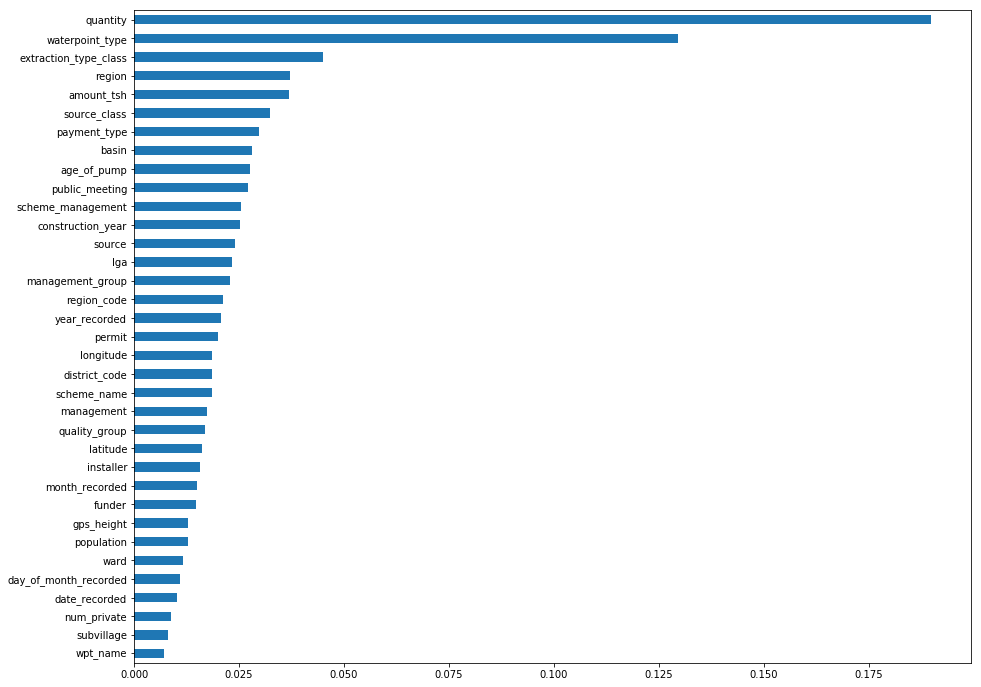

In [12]:
importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values(ascending=True)
plt.figure(figsize=(15,12))
top_n.plot.barh();
print(len(top_n))

In [21]:
!pip install eli5

     |████████████████████████████████| 102kB 1.9MB/s 


In [22]:

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring="accuracy", cv="prefit", n_iter=2, random_state=42 )

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=7,
                                              min_child_weight=1, missing=None,
                                              n_estimators=252, n_jobs=-1,
                                              nthread=None,
                                              objective='multi:softprob',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                    

In [23]:
feature_names = X_test.columns.tolist()

eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1262 ± 0.0011,quantity
0.0516 ± 0.0028,waterpoint_type
0.0425 ± 0.0003,extraction_type_class
0.0397 ± 0.0007,longitude
0.0346 ± 0.0007,latitude
0.0257 ± 0.0019,lga
0.0217 ± 0.0009,payment_type
0.0205 ± 0.0009,population
0.0179 ± 0.0017,subvillage
0.0176 ± 0.0011,ward


In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

numeric_features = ["latitude", "longitude", "amount_tsh", "age_of_pump"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['quantity', 'waterpoint_type', "extraction_type_class", "payment_type", "lga"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('ordinal', ce.OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=7, n_estimators=200))])

#X = train
#y = train_y['status_group']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

In [37]:
# lets submit this one

y_pred = clf.predict(test)

sample_submission = pd.read_csv('https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

from google.colab import files
submission.to_csv('LJ-sixth-submission.csv', index=False)
files.download('LJ-sixth-submission.csv')

AttributeError: ignored